In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
# Paths
LAND_COVER_TIF = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Data/worldcover_bbox_delhi_ncr_2021.tif"
FILTERED_CSV = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/filtered_images.csv"
OUTPUT_DIR = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/"
PLOT_DIR = "C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Scripts/plots"

In [19]:
src = rasterio.open(LAND_COVER_TIF)
print(f"Raster CRS: {src.crs}")

Raster CRS: EPSG:4326


In [14]:
ESA_CLASS_MAP = {
    10: 'Tree Cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare / Sparse vegetation',
    70: 'Snow & Ice',
    80: 'Water',
    90: 'Wetlands',
    95: 'Mangroves',
    100: 'Moss & Lichen'
}

In [15]:
PATCH_SIZE = 128  # pixels

# Read filtered images
df = pd.read_csv(FILTERED_CSV)

In [16]:
import os

In [ ]:
print("Raster CRS:", src.crs)
print("Example lat/lon:", lat, lon)

Raster CRS: EPSG:4326
Example lat/lon: 28.9942 77.6443


In [ ]:
lon = float(lon)
lat = float(lat)
x, y = src.index(lon, lat) #converting to float

In [23]:
print(f"Raster bounds: {src.bounds}")

Raster bounds: BoundingBox(left=76.84991666666667, bottom=28.2, right=77.65008333333334, top=29.0)


In [ ]:
print(f"Point: lon={lon}, lat={lat}")

Point: lon=76.9057, lat=28.6942


In [28]:
# Load land cover raster
src = rasterio.open(LAND_COVER_TIF)
nodata = src.nodata
print(f"Land cover nodata value: {nodata}")

labels = []
skipped = 0

for idx, row in df.iterrows():
    lat, lon = row['lat'], row['lon']
    # convert to pixel coords
    x, y = src.index(lon, lat)
    half = PATCH_SIZE // 2
    window = Window(x-half, y-half, PATCH_SIZE, PATCH_SIZE)
    try:
        patch = src.read(1, window=window)
        valid_patch = patch[patch != nodata]
        if len(valid_patch) < (PATCH_SIZE*PATCH_SIZE*0.5):  # >50% no-data
            skipped += 1
            continue
        mode_result = mode(valid_patch, axis=None)
        mode_val = mode_result.mode.item()
        label_name = ESA_CLASS_MAP.get(mode_val, f"Unknown-{mode_val}")
        labels.append({
            'file': row['file'],
            'lat': lat,
            'lon': lon,
            'label': label_name
        })
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")
        skipped += 1

print(f"Skipped {skipped} images due to no-data or errors")

labeled_df = pd.DataFrame(labels)
labeled_df.to_csv(os.path.join(OUTPUT_DIR, "labeled_dataset.csv"), index=False)

Land cover nodata value: 0.0
Skipped 0 images due to no-data or errors


In [29]:
# Train-test split
train_df, test_df = train_test_split(
    labeled_df,
    test_size=0.4,
    random_state=42,
    shuffle=True
)

train_df.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 4809, Test size: 3206


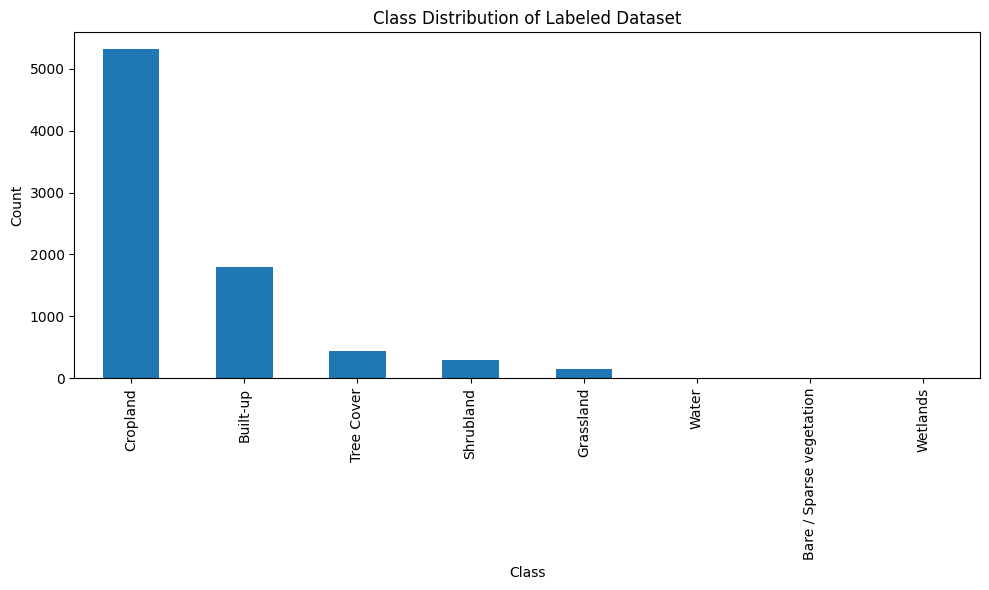

Class distribution plot saved: C:/Users/Namya/JobScreenTask/Project_root/venv_313/earth-observation-task/Scripts/plots/class_distribution.png


In [31]:
# Class distribution plot
plt.figure(figsize=(10,6))
labeled_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution of Labeled Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.savefig(f"{PLOT_DIR}/class_distribution.png")
plt.close()

print(f"Class distribution plot saved: {PLOT_DIR}/class_distribution.png")

The class distribution is highly imbalanced, dominated by “Cropland” and “Built-up” classes. Minority classes such as “Tree Cover” and “Shrubland” have significantly fewer samples, while some classes are nearly absent. This imbalance could bias the model toward majority classes. Mitigation strategies like class weighting and oversampling are recommended during training.